In [1]:
# Necessary imports
import os
import sys
import warnings

import numpy as np
warnings.filterwarnings("ignore")

sys.path.append('../../..')
from seismiqb.src.controllers.torch_models import EncoderDecoder, ExtensionModel
from seismiqb import MODEL_CONFIG_DETECTION, MODEL_CONFIG_EXTENSION
from seismiqb.src.controllers import Interpolator, Extender

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


Controllers are classes that wrap around train, inference and evaluation procedures in order to hold them in one place, with all the bells and whistles.

Each of them is configured with a nested dictionary, that describes how to use each of the methods.

In [2]:
# Global parameters
BAR = 't'

In [3]:
!rm -rf controller_extension/

config = {
    'savedir': 'controller_extension',
    'monitor': True,
    'bar': BAR,
    'plot': False,
    'sampler': {},
    'train': {
        'model_class': ExtensionModel,
        'model_config': MODEL_CONFIG_EXTENSION,
        
        'batch_size': 64,
        'crop_shape': (1, 128, 128),

        'adaptive_slices': False,
        'side_view': True,
        'width': 3,

        'rebatch_threshold': 0.8,
        'rescale_batch_size': True,
        
        'prefetch': 1,
        'n_iters': 150,
        'early_stopping': True,
    },
    'inference': {
        'batch_size': 128,
        'crop_shape': (1, 128, 128),
        'prefetch': 0,
        
        'n_steps': 32,
        'stride': 32,
    },
    'evaluate': {
        'n': 1,
        'supports': 100,
        'dump': False,
        'device': 'gpu',
    },
}

In [4]:
extender = Extender(config)

In [5]:
%%time
dataset = extender.make_dataset(
    cube_paths='/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5',
    horizon_paths='/data/seismic_data/seismic_interpretation/CUBE_01_ETP/INPUTS/HORIZONS/RAW/etp_B_anon',
)

CPU times: user 3.52 s, sys: 628 ms, total: 4.15 s
Wall time: 4.05 s


In [6]:
horizon = dataset.labels[0][0].__copy__()

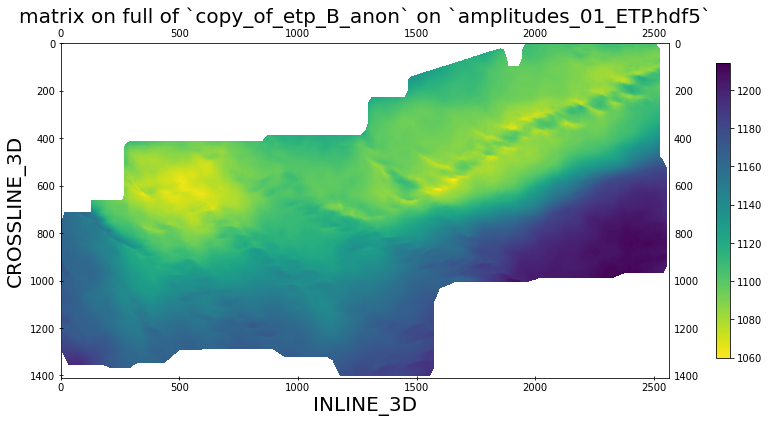

In [7]:
horizon.show()

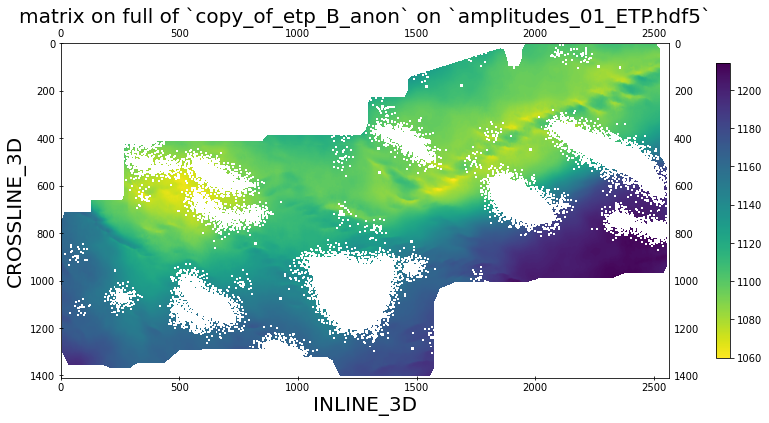

In [8]:
# Artificially add holes so that extension has to do some work
filtering_matrix = horizon.make_random_holes_matrix(n=20, points_proportion=1e-5, points_shape=5, noise_level=25, seed=0)
horizon.filter(filtering_matrix=filtering_matrix)
horizon.show()

In [9]:
%%time
model = extender.train(horizon=horizon)

loss_history=0.071697: 100%|████████████████████████████| 150/150 [01:27<00:00,  1.72it/s]


CPU times: user 1min 44s, sys: 37.4 s, total: 2min 21s
Wall time: 1min 39s


In [10]:
%%time
prediction = extender.inference(horizon, model)

Extender inference: 100%|███████████████████████| 32/32 [03:22<00:00,  6.31s/it]


CPU times: user 2min 46s, sys: 26.2 s, total: 3min 12s
Wall time: 3min 24s


In [11]:
prediction = extender.postprocess(prediction)

In [12]:
%%time
info = extender.evaluate(prediction, dataset=dataset)

CPU times: user 23.7 s, sys: 8.32 s, total: 32.1 s
Wall time: 19.9 s


In [13]:
info

[{'mean': -0.00022937312654548395,
  'diffs': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'spatial_position': 'overlap',
  'abs_mean': 0.01058334206546375,
  'max': 7,
  'abs_max': 7,
  'std': 0.10988648624452059,
  'abs_std': 0.10937589013088668,
  'window_rate': 0.9998754124384591,
  'offset_diffs': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'corrs': 0.8594953,
  'phase': 0.1705068378712428,
  'perturbed_mean': 0.4497770612187136,
  'perturbed_max': 0.2147253901930872}]

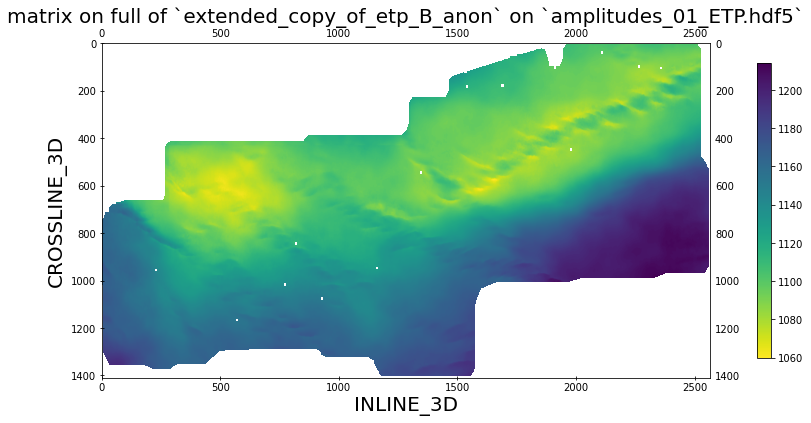

In [14]:
prediction.show()

In [105]:
def l1_metric_in_holes(horizon_with_holes, true_horizon, predicted_horizon):
    horizon_with_holes_matrix = horizon_with_holes.full_matrix
    true_horizon_matrix = true_horizon.full_matrix
    predicted_horizon_matrix = predicted_horizon.full_matrix
    metric = np.where((true_horizon_matrix != true_horizon.FILL_VALUE) & \
                      (predicted_horizon_matrix != predicted_horizon.FILL_VALUE) & \
                      (horizon_with_holes_matrix == horizon_with_holes.FILL_VALUE),
                       true_horizon_matrix - predicted_horizon_matrix, np.nan)
    return np.nansum(np.abs(metric))


In [106]:
l1_metric_in_holes(horizon, dataset.labels[0][0], prediction)

18934.0


Comparing horizons:
                                   etp_B_anon
                  extended_copy_of_etp_B_anon
—————————————————————————————————————————————
Rate in 5ms:                            1.000
Mean/std of errors:               0.00 / 0.11
Mean/std of abs errors:           0.01 / 0.11
Max error/abs error:                 6 /    7
—————————————————————————————————————————————
Lengths of horizons:                  2424324
                                      2431875
—————————————————————————————————————————————
Average heights of horizons:          1130.12
                                      1130.22
—————————————————————————————————————————————
Coverage of horizons:                  0.9953
                                       0.9984
—————————————————————————————————————————————
Solidity of horizons:                  1.0000
                                       1.0000
—————————————————————————————————————————————
Number of holes in horizons:                0
             

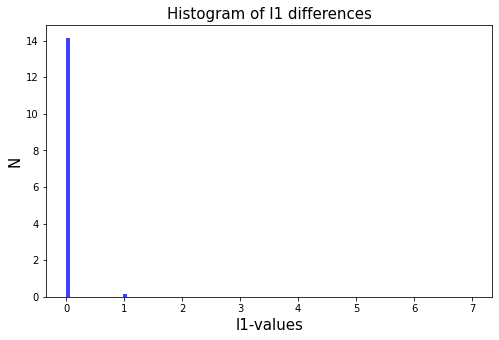

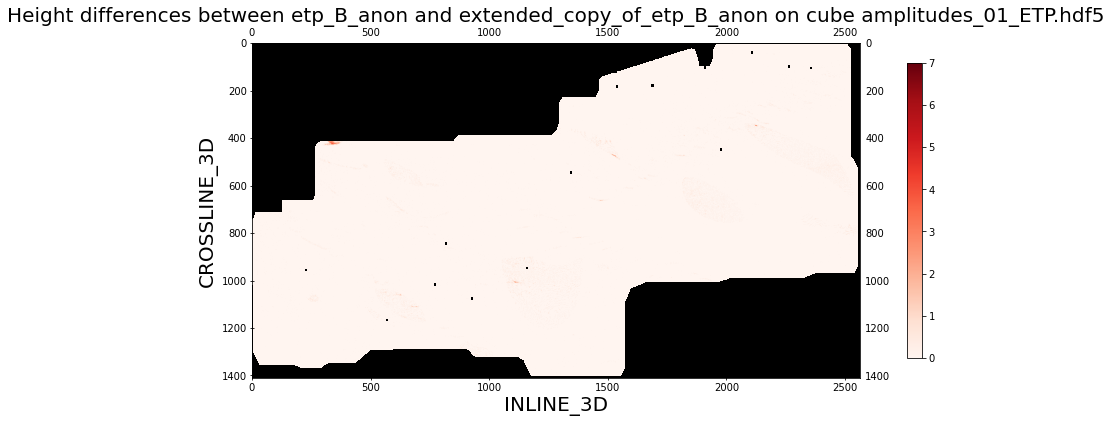

In [65]:
from seismiqb import HorizonMetrics
hm = HorizonMetrics((dataset.labels[0][0], prediction))

_ = hm.evaluate('compare', plot=True)